<a href="https://colab.research.google.com/github/CarlosAltamiranoR/recommender_system/blob/rs_2024/ModeloKeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [2]:
# Cargar el archivo datos_movies.csv
movies_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/movies.csv')

# Cargar el archivo datos_movies_list.csv
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/resultados.csv')


# Limpieza

In [3]:
# Calcular el número de películas en cada lista
list_sizes = data.groupby('ID_Lista').size()

# Mostrar estadísticas descriptivas
print("Estadísticas de tamaños de listas:")
print(list_sizes.describe())


Estadísticas de tamaños de listas:
count    51820.000000
mean        10.198244
std         62.458949
min          1.000000
25%          1.000000
50%          1.000000
75%          4.000000
max       3853.000000
dtype: float64


## mostrar graficamente distribución

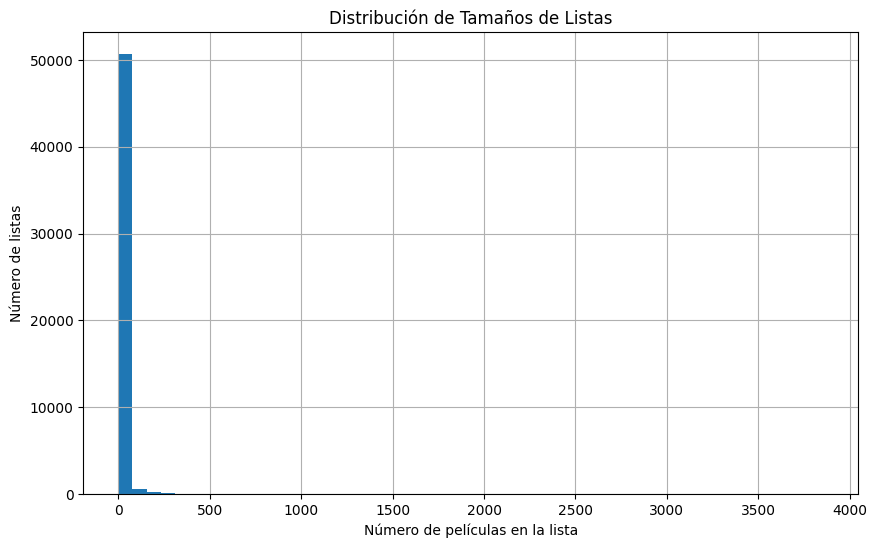

In [4]:
plt.figure(figsize=(10,6))
list_sizes.hist(bins=50)
plt.title('Distribución de Tamaños de Listas')
plt.xlabel('Número de películas en la lista')
plt.ylabel('Número de listas')
plt.show()

In [5]:
# Definir un umbral para listas muy cortas (por ejemplo, menos de 2 películas)
short_list_threshold = 3

# Filtrar listas muy cortas
short_lists = list_sizes[list_sizes < short_list_threshold]

print(f"Número de listas con menos de {short_list_threshold} películas: {len(short_lists)}")
print("IDs de listas muy cortas:")
print(short_lists.index.tolist())

Número de listas con menos de 3 películas: 34847
IDs de listas muy cortas:
[16, 456, 524, 526, 533, 615, 663, 1002, 1264, 1323, 1425, 2108, 2118, 2527, 2629, 3346, 3347, 3352, 4260, 4333, 4402, 4416, 4575, 4614, 4963, 4978, 5797, 5872, 6374, 6404, 6428, 6654, 7652, 7722, 7943, 8061, 8275, 8446, 8472, 8592, 8899, 8922, 8995, 9128, 9136, 9262, 9312, 9406, 9954, 10347, 10589, 10596, 10720, 10918, 11064, 11123, 11288, 12044, 12048, 12553, 12919, 13344, 13518, 13621, 13884, 13937, 14052, 14055, 14179, 16095, 16403, 16469, 16661, 16888, 17814, 17881, 18180, 18328, 18498, 18502, 18561, 18988, 19385, 19618, 19649, 19676, 19683, 19904, 19932, 19940, 19952, 20009, 20065, 20090, 20118, 20125, 20162, 20266, 20592, 20921, 21085, 21130, 21289, 21347, 21399, 21530, 21606, 21684, 21809, 21819, 21877, 22441, 22504, 22617, 23409, 23436, 23604, 23671, 23874, 24068, 24572, 24727, 24822, 24825, 24835, 24854, 24855, 25073, 25077, 25225, 25570, 25890, 26043, 26165, 26227, 26261, 26285, 26312, 26806, 27080, 2

In [6]:
# Filtrar las listas que cumplen con el tamaño mínimo
valid_list_ids = list_sizes[list_sizes >= short_list_threshold].index
data = data[data['ID_Lista'].isin(valid_list_ids)]

In [7]:
# Contar cuántas veces aparece cada película en las listas
movie_counts = data['ID_Pelicula'].value_counts()

# Mostrar estadísticas descriptivas
print("Estadísticas de frecuencias de películas:")
print(movie_counts.describe())

Estadísticas de frecuencias de películas:
count    4528.000000
mean      107.498454
std        23.046816
min         1.000000
25%       109.000000
50%       117.000000
75%       119.000000
max       120.000000
Name: count, dtype: float64


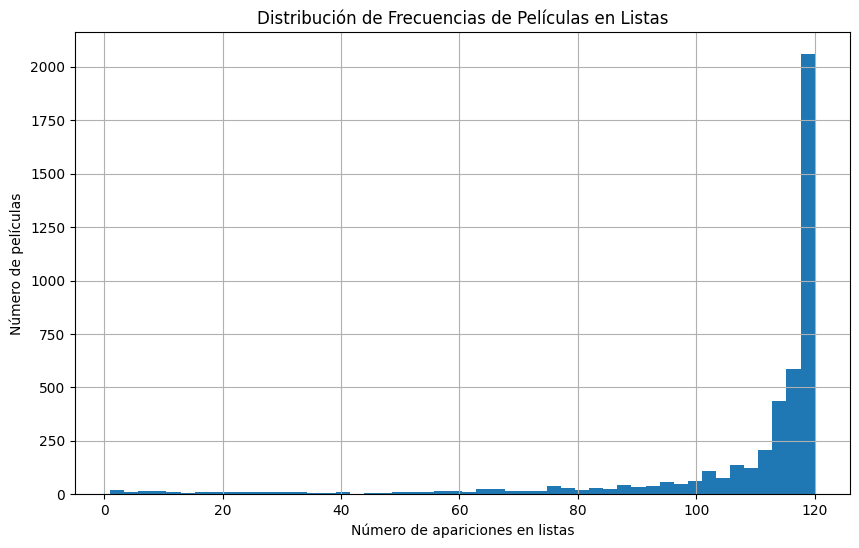

In [8]:
plt.figure(figsize=(10,6))
movie_counts.hist(bins=50)
plt.title('Distribución de Frecuencias de Películas en Listas')
plt.xlabel('Número de apariciones en listas')
plt.ylabel('Número de películas')
plt.show()

In [9]:
# Definir un umbral para películas muy frecuentes (por ejemplo, aparecen en más del 5% de las listas)
frequency_threshold = data['ID_Lista'].nunique() * 0.05

frequent_movies = movie_counts[movie_counts > frequency_threshold]

print(f"Número de películas que aparecen en más del 5% de las listas: {len(frequent_movies)}")
print("IDs de películas muy frecuentes:")
print(frequent_movies.index.tolist())

Número de películas que aparecen en más del 5% de las listas: 0
IDs de películas muy frecuentes:
[]


ninguna película aparece en más del 5% de las listas. Es decir, no hay películas que sean extremadamente frecuentes en el conjunto de datos.

**Implicaciones**: Dado que no hay películas que aparezcan con tanta frecuencia, el problema de que el modelo recomiende siempre las mismas películas no se debe a que ciertas películas estén sobre-representadas en los datos.

In [10]:
# Contar la frecuencia de cada película
movie_counts = data['ID_Pelicula'].value_counts()
print(movie_counts.head(1000))  # Ver las 10 películas más frecuentes


ID_Pelicula
10549     120
8987      120
10858     120
11545     120
9826      120
         ... 
591       119
3033      119
18900     119
9676      119
181533    119
Name: count, Length: 1000, dtype: int64


# Modelo IA

In [11]:
# Obtener el conjunto de IDs de películas presentes en datos_movies_list.csv
movie_ids_in_list = set(data['ID_Pelicula'].astype(str))

# Filtrar movies_df para que solo contenga películas en movie_ids_in_list
movies_df = movies_df[movies_df['id'].astype(str).isin(movie_ids_in_list)].reset_index(drop=True)


In [12]:
# Convertir IDs a string para consistencia
data['ID_Pelicula'] = data['ID_Pelicula'].astype(str)
data['ID_Lista'] = data['ID_Lista'].astype(str)

# Obtener el conjunto de todos los IDs de películas
all_movie_ids = set(data['ID_Pelicula'])

# Crear un diccionario que mapea ID_Lista a un conjunto de IDs de películas
list_to_movies = data.groupby('ID_Lista')['ID_Pelicula'].apply(set).to_dict()


In [13]:
# Crear un diccionario que mapea ID_Pelicula a un índice único
movie_id_to_index = {movie_id: idx for idx, movie_id in enumerate(sorted(all_movie_ids))}
index_to_movie_id = {idx: movie_id for movie_id, idx in movie_id_to_index.items()}

# Número total de películas
num_movies = len(movie_id_to_index)


In [14]:
# Obtener todos los IDs de listas
all_list_ids = list(list_to_movies.keys())

# Dividir en entrenamiento y prueba
train_list_ids, test_list_ids = train_test_split(all_list_ids, test_size=0.5, random_state=42)


In [15]:
def create_dataset(list_ids):
    X = []
    Y = []
    for list_id in list_ids:
        movies_in_list = list(list_to_movies[list_id])
        num_movies_in_list = len(movies_in_list)

        if num_movies_in_list < 2:
            continue  # Saltar listas con menos de 2 películas

        # Seleccionar aleatoriamente entre 2 y 5 películas para x
        num_movies_in_x = min(random.randint(1, 5), num_movies_in_list)
        movies_in_x = random.sample(movies_in_list, num_movies_in_x)

        # Crear vector x
        x = np.zeros(num_movies)
        for movie_id in movies_in_x:
            idx = movie_id_to_index[str(movie_id)]
            x[idx] = 1

        # Crear vector y
        y = np.zeros(num_movies)
        for movie_id in movies_in_list:
            idx = movie_id_to_index[str(movie_id)]
            y[idx] = 1

        # Agregar a los conjuntos de datos
        X.append(x)
        Y.append(y)
    return np.array(X), np.array(Y)


In [16]:
X_train, Y_train = create_dataset(train_list_ids)
X_test, Y_test = create_dataset(test_list_ids)


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import EarlyStopping

# Definir el modelo
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=num_movies))
model.add(Dense(256, activation='relu'))
model.add(Dense(num_movies, activation='sigmoid'))  # Usamos sigmoid para salida multi-etiqueta

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])

# Entrenar el modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_split=0.1, callbacks=[early_stopping])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 8.0608e-05 - loss: 0.2829 - precision: 0.0131 - recall: 0.0506 - val_accuracy: 0.0000e+00 - val_loss: 0.0399 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 8.5741e-04 - loss: 0.0324 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0407 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 4.5603e-04 - loss: 0.0319 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0414 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 2.2614e-04 - loss: 0.0298 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0012 - val_loss: 0.0421 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.00

In [18]:
import sys
import os
import contextlib

@contextlib.contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

def get_recommendations(input_movie_id, top_n=5):
    # Crear vector x con una sola película
    x = np.zeros(num_movies)
    idx = movie_id_to_index[str(input_movie_id)]
    x[idx] = 1

    # Suprimir la salida estándar durante la predicción
    with suppress_stdout():
        y_pred_prob = model.predict(np.array([x]))[0]

    # Obtener los índices de las top_n predicciones
    recommended_indices = np.argsort(y_pred_prob)[::-1]

    # Filtrar películas que no sean la película de entrada
    recommended_indices = [i for i in recommended_indices if i != idx]

    # Obtener los IDs de las películas recomendadas
    recommended_movie_ids = [index_to_movie_id[i] for i in recommended_indices[:top_n]]

    # Obtener los nombres de las películas recomendadas
    recommended_movies = movies_df[movies_df['id'].astype(str).isin(recommended_movie_ids)]

    return recommended_movies[['id', 'title']]




In [19]:
def get_movie_names(movie_ids):
    return movies_df[movies_df['id'].astype(str).isin(movie_ids)]['title'].tolist()

In [20]:
# Evaluar las recomendaciones
results = []

# Limitar el número de listas de prueba
max_test_lists = 100
test_list_ids_subset = random.sample(test_list_ids, min(max_test_lists, len(test_list_ids)))

for list_id in test_list_ids_subset:
    movies_in_list = list(list_to_movies[list_id])
    num_movies_in_list = len(movies_in_list)

    if num_movies_in_list < 3:
        continue  # Saltar listas con menos de 3 películas

    # Seleccionar una película al azar de la lista
    input_movie_id = random.choice(movies_in_list)

    # Obtener recomendaciones
    recommended_movies = get_recommendations(input_movie_id, top_n=5)

    # Obtener los IDs y nombres de las películas recomendadas
    recommended_movie_ids = set(recommended_movies['id'].astype(str))
    recommended_movie_names = recommended_movies['title'].tolist()

    # Películas correctas (que están en la misma lista)
    actual_movie_ids = set(movies_in_list)
    #actual_movie_ids.discard(input_movie_id)  # Excluir la película de entrada

    # Contar cuántas recomendaciones están en la misma lista
    correct_recommendations = recommended_movie_ids.intersection(actual_movie_ids)
    num_correct = len(correct_recommendations)
    correct_recommendation_names = get_movie_names(correct_recommendations)

    # Porcentaje de acierto
    possible_correct = min(5, len(actual_movie_ids))
    hit_percentage = num_correct / possible_correct if possible_correct > 0 else 0

    # Guardar resultados
    results.append({
        'ID_Lista': list_id,
        'Película_Entrada_ID': input_movie_id,
        'Película_Entrada_Nombre': movies_df[movies_df['id'].astype(str) == input_movie_id]['title'].values[0],
        'Recomendaciones_IDs': list(recommended_movie_ids),
        'Recomendaciones_Nombres': recommended_movie_names,
        'Películas_Correctas_IDs': list(actual_movie_ids),
        'Películas_Correctas_Nombres': get_movie_names(actual_movie_ids),
        'Aciertos_Nombres': correct_recommendation_names,
        'Aciertos': num_correct,
        'Posibles_Aciertos': possible_correct,
        'Porcentaje_Acierto': hit_percentage
    })


# Analizar resultados

In [21]:
results_df = pd.DataFrame(results)

# Calcular el porcentaje medio de aciertos
mean_hit_percentage = results_df['Porcentaje_Acierto'].mean()
print(f"Porcentaje medio de aciertos: {mean_hit_percentage:.2%}")

# Mostrar algunos resultados
results_df[['Película_Entrada_Nombre', 'Recomendaciones_Nombres', 'Aciertos_Nombres', 'Porcentaje_Acierto']].head()



Porcentaje medio de aciertos: 0.80%


,Película_Entrada_Nombre,Recomendaciones_Nombres,Aciertos_Nombres,Porcentaje_Acierto
0,Trekkies,"[Speed 2: Cruise Control, The Specialist, Welc...",[],0.0
1,When a Stranger Calls,"[Speed 2: Cruise Control, The Specialist, Welc...",[],0.0
2,An Ideal Husband,"[Speed 2: Cruise Control, Primary Colors, Welc...",[],0.0
3,30 Nights of Paranormal Activity With the Devi...,"[Speed 2: Cruise Control, The Specialist, Welc...",[],0.0
4,Autumn in New York,"[Speed 2: Cruise Control, The Specialist, Welc...",[],0.0
